# Text Mining Project - Stock Sentiment - Test Notebook

## *Predicting market behavior from tweets*

### Group 42

Carolina Pinto - 20240494 <br>
Fábio dos Santos - 20240678 <br>
Guilherme – 2024 <br>
Mariana – 2024 <br>

## Table of Contents
- [1. Import Libraries](#1-import-libraries)
- [2. Data Integration](#2-data-integration)
   - [2.1 Data Description](#21-data-description)
- [3. Data Content](#3-data-content)
- [4. Data Exploration](#4-data-exploration)
   - [4.1. Class Distribution](#41-class-distribution)
   - [4.2. Text Length](#42-text-length)
   - [4.3. Data Manipulation for Further Exploration](#43-data-manipulation-for-further-exploration)
   - [4.4. Most Frequent Words per Label](#44-most-frequent-words-per-label)
   - [4.5. Word Cloud by Label](#45-word-cloud-by-label)
- [5. Corpus Split](#5-corpus-split)
- [6. Data Preprocessing](#6-data-preprocessing)
- [7. Feature Engineering](#7-feature-engineering)
- [8. Classification Models](#8-classification-models)
- [9. Evaluation](#9-evaluation)

# 1. Import libraries

`Step 1` Import the required libraries.

In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import gensim.downloader
import gensim.downloader as api
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from langchain_openai import AzureChatOpenAI
from openai import AzureOpenAI


import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences
import torch

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Data Integration

`Step 2` Import the dataset __train.csv__ using the method **read_csv()** from pandas.

In [2]:
df = pd.read_csv('../Project_Data/train.csv')

## 2.1. Data Description

`text`: tweets content. <br>
`label`: sentimental label, it can be bearish (0), bullish (1) or neutral (2).

# 3. Data Content

`Step 3` Check the first 5 rows of the dataset.

In [3]:
df.head(20)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


`Step 4` Check the number of rows and columns of the data frame.

In [4]:
df.shape

(9543, 2)

`Step 5` Check the features data types and info.

In [5]:
df.dtypes

text     object
label     int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


#### Conclusions
- Our data is composed of **9543** observations and **2** columns. <br>
- Variable text is object and variable label is an integer as expected. <br>
- There are no null values in the observations. <br>
- Our tweets have a lot of "noise" letters and symbols like hashtags, dollar signs, links, punctuation and numbers. This should be adressed later on.

# 4. Data Exploration

`Step 6` Defining the colors to use in our visualizations for consistent representation (NOVA IMS official colors).

In [7]:
color_390 = (190/255, 214/255, 47/255)  # Pantone 390 C
color_431 = (92/255, 102/255, 108/255)  # Pantone 431 C

## 4.1. Class Distribution

`Step 7` Check Class Distribution (plot and percentage).

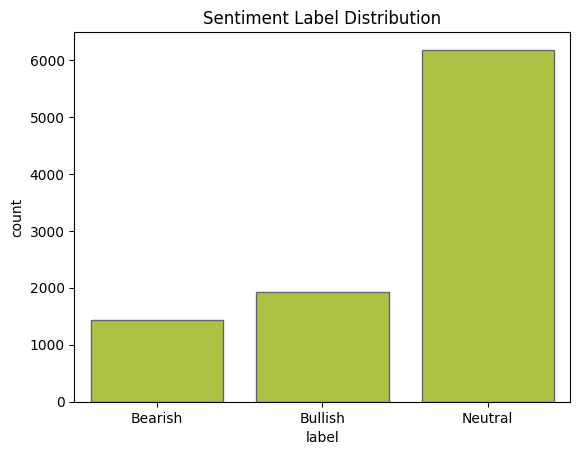

label
2    64.738552
1    20.150896
0    15.110552
Name: proportion, dtype: float64


In [8]:
sns.countplot(data=df, x='label', color=color_390, edgecolor=color_431)
plt.title("Sentiment Label Distribution")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

print(df['label'].value_counts(normalize=True) * 100)

- We can see that our labels are unbalanced, more than 60% is classified as "Neutral", 20% as "Bullish" and 15% as "Bearish".

## 4.2. Text Length

`Step 8` Check Text Length of the tweets per label.

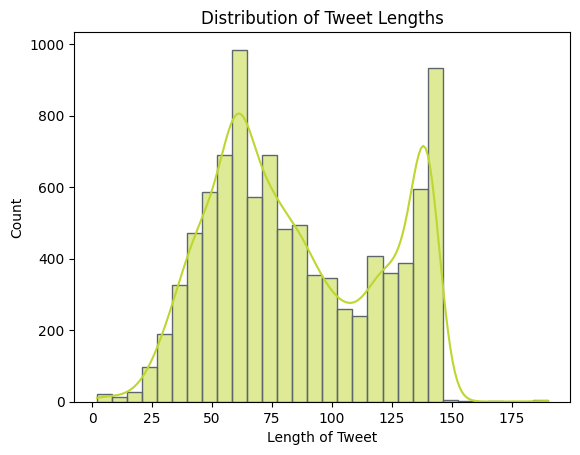

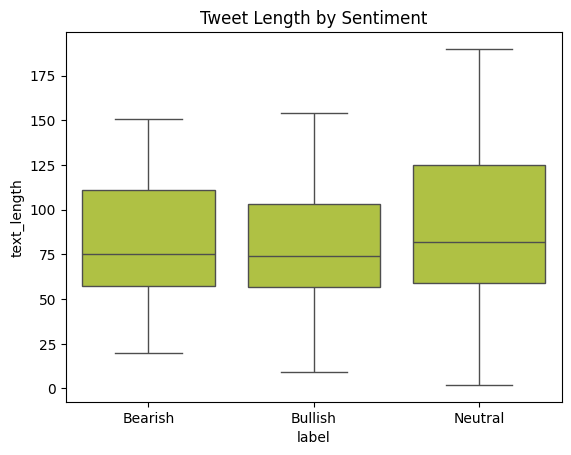

In [9]:
df['text_length'] = df['text'].apply(len)

sns.histplot(df['text_length'], bins=30, kde=True, color=color_390, edgecolor=color_431)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Length of Tweet")
plt.show()

# Grouped by label
sns.boxplot(data=df, x='label', y='text_length', color=color_390)
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.title("Tweet Length by Sentiment")
plt.show()

- The different labels have a simillar distribution in terms of tweet length. <br>
- The tweets length are distributed in a normal distribution with two peaks at length between 60-65 and 140-145. <br> 
- There are a lot of tweets (approximately 1000) with length between 60-65, and around 900 with length between 140-145. This represents approximately 19% of the data. 

## 4.3. Data Manipulation for Further Exploration

- We want to check the most frequent words per label and the word clouds for each label. At this point our data is raw and we wouldn't get significant analysis. <br>
- For that reason in this section we will copy our dataset in order to do a small preprocessing (tokenize) and then perform the desired analysis. <br>
- After this data manipulation and the referred two analysis we will continue our work with corpus split and data preprocessing from the original dataset.

`Step 9` Using a copy of our dataset we tokenize the tweets in order to have a more accurate analysis.

In [10]:
df_copy = deepcopy(df)

stop_words = set(stopwords.words('english'))

# Preprocessing: basic cleaning and tokenization
def clean_and_tokenize(text):
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text)  
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

df_copy['tokens'] = df_copy['text'].apply(clean_and_tokenize)

df_copy

,text,label,text_length,tokens
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77,"[bynd, jpmorgan, reels, expectations, beyond, ..."
1,$CCL $RCL - Nomura points to bookings weakness...,0,102,"[ccl, rcl, nomura, points, bookings, weakness,..."
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94,"[cx, cemex, cut, credit, suisse, jp, morgan, w..."
3,$ESS: BTIG Research cuts to Neutral https://t....,0,59,"[ess, btig, research, cuts, neutral]"
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,71,"[fnko, funko, slides, piper, jaffray, pt, cut]"
...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,136,"[weeks, gainers, losers, stoxx, europe, dec, e..."
9539,Tupperware Brands among consumer gainers; Unil...,2,67,"[tupperware, brands, among, consumer, gainers,..."
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,89,"[vtv, therapeutics, leads, healthcare, gainers..."
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,47,"[work, xpo, pyx, amkr, among, hour, movers]"


## 4.4. Most Frequent Words per Label

`Step 10` Check top 10 most frequent words per label. 


Top 10 words for Bearish tweets:
stock: 148
us: 99
misses: 85
coronavirus: 79
oil: 78
economy: 68
market: 66
stocks: 64
price: 64
china: 63


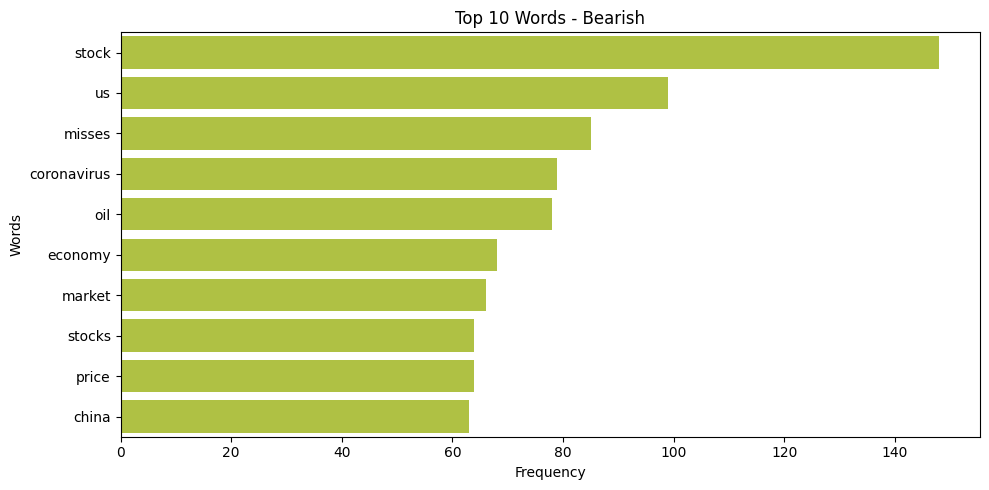


Top 10 words for Bullish tweets:
stock: 255
beats: 164
price: 137
us: 120
target: 117
stocks: 114
shares: 112
revenue: 106
market: 101
new: 97


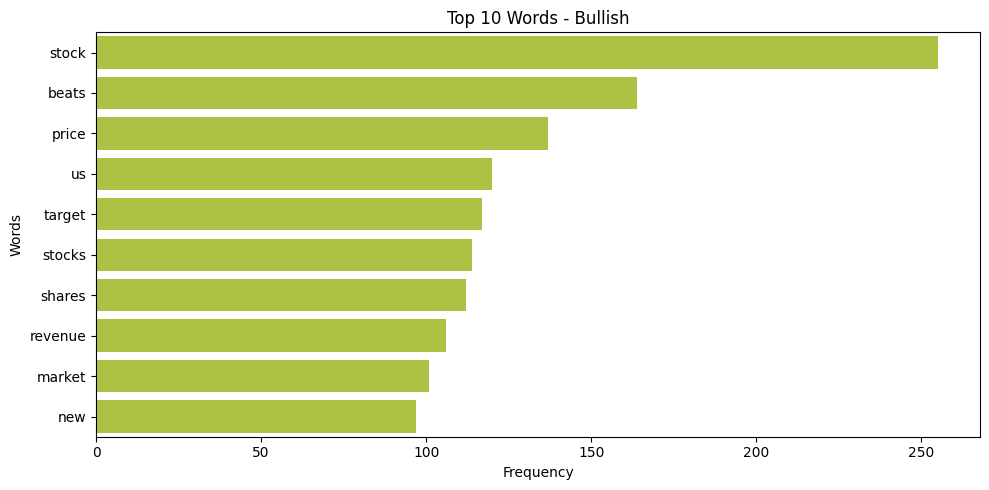


Top 10 words for Neutral tweets:
stock: 570
marketscreener: 376
results: 315
new: 285
earnings: 256
us: 233
says: 233
dividend: 225
reports: 222
inc: 195


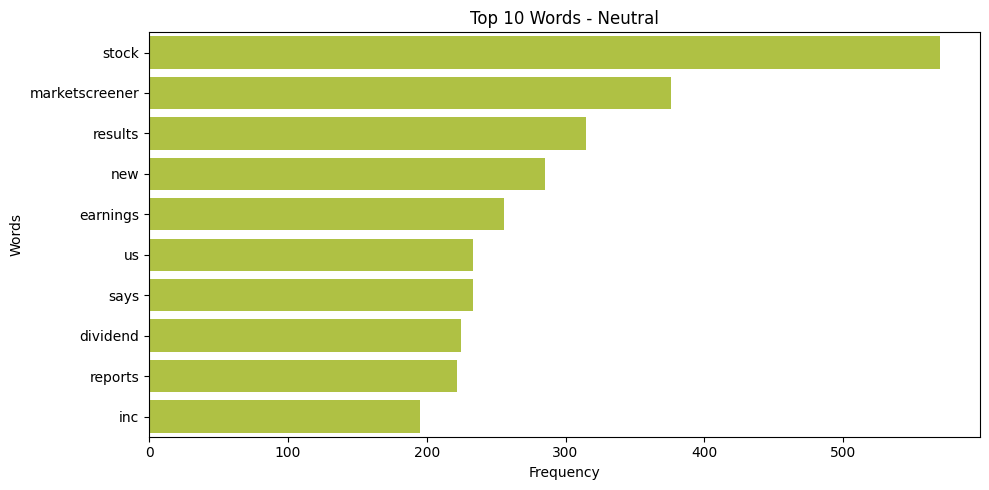

In [11]:
# Map labels to names
label_names = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Show top 10 words per label
def get_top_words(df, label, top_n=10):
    all_words = [word for tokens in df[df['label'] == label]['tokens'] for word in tokens]
    most_common = Counter(all_words).most_common(top_n)

    print(f"\nTop {top_n} words for {label_names[label]} tweets:")
    for word, count in most_common:
        print(f"{word}: {count}")

    # Plot
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), color=color_390)
    plt.title(f"Top {top_n} Words - {label_names[label]}")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

# Loop through each label
for label in sorted(df_copy['label'].unique()):
    get_top_words(df_copy, label, top_n=10)

In [12]:
df_copy.text_length.describe()

count    9543.000000
mean       85.858325
std        35.138568
min         2.000000
25%        58.000000
50%        79.000000
75%       120.000000
max       190.000000
Name: text_length, dtype: float64

- All three labels have the same most common word as "stock" but also a good amount of the plural "stocks". <br>
- "us" also have a good representation in all the 3 labels. <br>
- Even though there is a significance difference between labels there are still some common words between them. <br>
- Neutral tweets don't have such a big gap between the top 5 most common words, which makes the words distribution more balanced. <br>
- The largest tweet have 190 words while the smallest one have 2. <br>
- In average the tweets have around 79 words. 

## 4.5. Word Cloud by Label

`Step 11` Check Word Cloud of the different labels.

Word cloud for Bearish label:


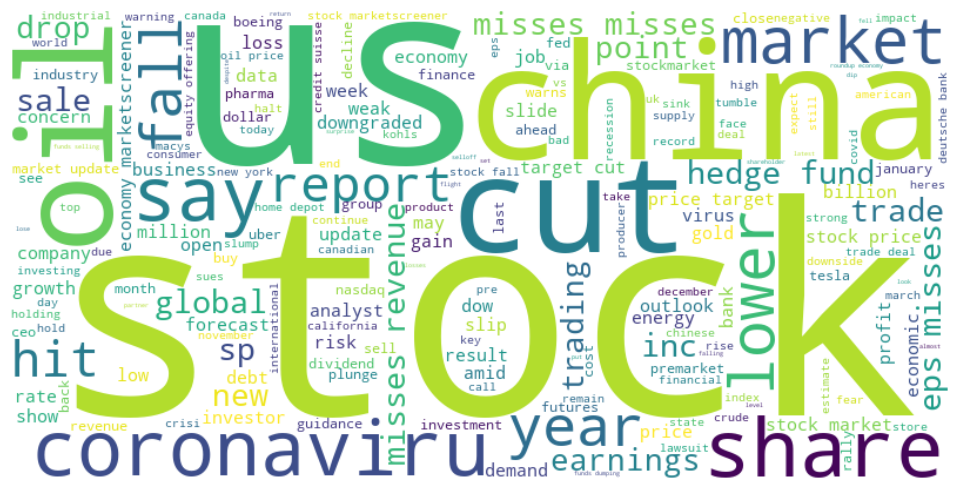

Word cloud for Bullish label:


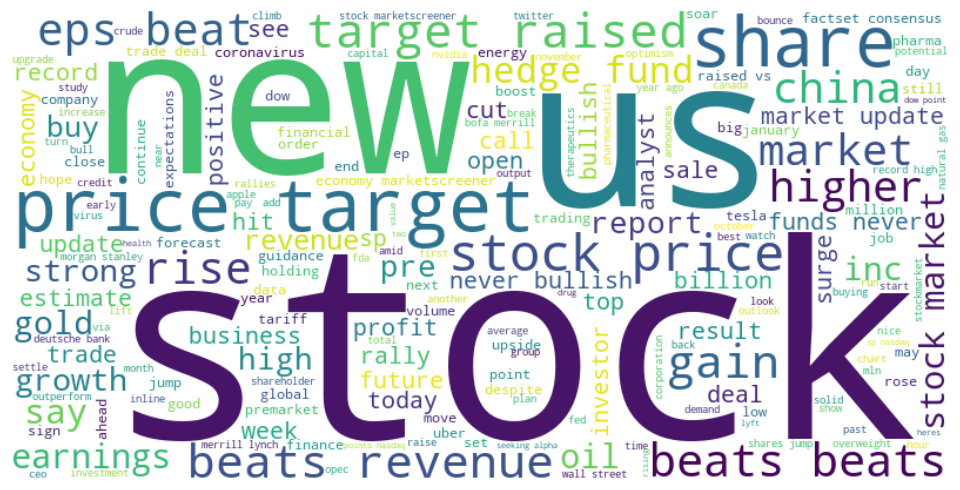

Word cloud for Neutral label:


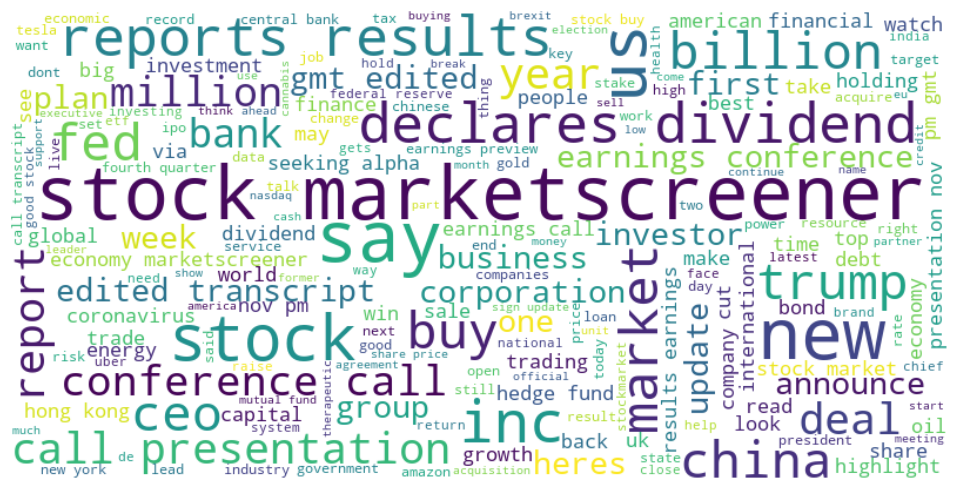

In [13]:
def plot_wordcloud(df, label, label_names):
    # Combine all tokens into one string
    text = " ".join(df[df['label'] == label]['tokens'].sum())
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis').generate(text)
    
    print(f"Word cloud for {label_names[label]} label:")

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate word clouds for each label
for label in sorted(df_copy['label'].unique()):
    plot_wordcloud(df_copy, label, label_names)

- As previously observed, “stock” appears as the most prominent word across all sentiment labels. However, in the Neutral label, it stands out less clearly due to a more even distribution among the top words. <br>
- Overall, the Neutral label exhibits a more balanced word frequency distribution compared to the Bearish and Bullish labels. This aligns with expectations: neutral tweets typically lack strong sentiment indicators, resulting in fewer dominant or sentiment-specific keywords that clearly classify the text as bullish or bearish.

# 5. Corpus Split

- Since our corpus have less than 10000 rows we would split it in train, validation and test in a 80%/10%/10% split. In our project we have a separate test csv file therefore we'll use it as our test. We will split this data in train and validation in a 80%/20% split.

`Step 12` Create a copy of the original dataframe named **data**.

In [14]:
data = deepcopy(df)
data

,text,label,text_length
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77
1,$CCL $RCL - Nomura points to bookings weakness...,0,102
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94
3,$ESS: BTIG Research cuts to Neutral https://t....,0,59
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,71
...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,136
9539,Tupperware Brands among consumer gainers; Unil...,2,67
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,89
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,47


__`Step 13`__ Create a varaible called `X` that store the values of the input features and `y` that stores the values of the target feature.

In [15]:
X = data.drop(columns=['label'], axis =1)
y = data['label']  

__`Step 14`__ Split the data in train and validation set in a 80/20 split, with random_state = 42, stratification by y and with shuffle of the dataset.

In [16]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y, 
                                                    shuffle=True
                                                    )

- This first split was made for testing the preprocessing methods. For feature selection and model assessment and optimization we will use cross validation with the preprocessing inside.

# 6. Data Preprocessing

<span style="color:red">
PARA OPTIMIZAR O MODELO: </span> <br>
- Procurar diferentes lemmatizers e stemmers e testa-los em gridsearch para ver qual o melhor modelo <br>
- Procurar outras formas de preprocessing (corrigir typos, etc etc)<br>
- Temos de aplicar o preprocessement ao test?


__`Step 15`__ Create a function to do the data preprocessing. It includes:<br>
|Preprocessement                                  |
|------------------------------------|
| Lowercasing | 
| Removes Regular Unwanted Expressions   | 
| Remove Punctuation           | 
| Tokenization |
| Remove Stop Words                    | 
| Lemmatization |
| Stemming                    |

In [17]:
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def preprocess(text_list, lemma = None, stemmer = None, word2vec=False):
    """
    Return the prepocessed text in a list "updates".

    Parameters:
    text_list : list to be preprocessed
    use_lemmatize : bool, optional
        If True, applies lemmatization to the tokens. Default is True.
    use_stemmer : bool, optional
        If True, applies stemming to the tokens. Default is False.
    """

    stop_words = set(stopwords.words('english'))

    updates = []

    for j in tqdm(text_list):

        text = j

        # Lower case text
        text = text.lower()

        # Remove Regular Unwanted Expressions
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)  
        text = re.sub(r'@\w+|#\w+', '', text)              
        text = re.sub(r'\d+', '', text)

        # Remove Punctuation                     
        text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

        # Tokenize the text
        tokens = word_tokenize(text) 

        #Remove Stopwords
        tokens = [word for word in tokens if word not in stop_words]

        #Lemmatize
        if lemma:
            tokens = [lemma.lemmatize(word) for word in tokens]

        #Stemming
        if stemmer:
            tokens = [stemmer.stem(word) for word in tokens]

        # Rejoin tokens

        if word2vec:
            cleaned_text=tokens
        else:
            cleaned_text = " ".join(tokens)

        updates.append(cleaned_text)

    return updates

__`Step 16`__ Apply the preprocessement to X_train and X_val.

In [18]:
X_train['tokens'] = preprocess(X_train['text'])
X_train

100%|██████████| 7634/7634 [00:00<00:00, 23348.71it/s]


,text,text_length,tokens
2186,Nasdaq prices 600M of 0.875% senior notes,41,nasdaq prices senior notes
6819,Futures up https://t.co/diz7v5lmVb,34,futures
6157,$ECONX: November Nonfarm Private Payrolls 125K...,112,econx november nonfarm private payrolls k vs k...
2462,Twitter users explain why Kohl's stock just go...,136,twitter users explain kohls stock got oblitera...
4097,Agilysys : Restaurants Find Sustainable Method...,133,agilysys restaurants find sustainable methods ...
...,...,...,...
2807,Japan Tobacco reports FY results,32,japan tobacco reports fy results
704,The Fed's Emergence as a Power Player Poses Ne...,123,feds emergence power player poses new risks in...
990,How the Rise of At-Home Fitness Services Could...,74,rise athome fitness services could benefit lul...
4362,Daniel Loeb's Top 5 Buys in the 3rd Quarter,43,daniel loebs top buys rd quarter


In [19]:
X_val['tokens'] = preprocess(X_val['text'])
X_val

  0%|          | 0/1909 [00:00<?, ?it/s]

100%|██████████| 1909/1909 [00:00<00:00, 25447.25it/s]


,text,text_length,tokens
4693,i love it when fertility clinic's decorate ......,126,love fertility clinics decorate even thanks gi...
1599,IRS investigators scrutinize Bitcoin ATMs and ...,52,irs investigators scrutinize bitcoin atms kiosks
9238,$SRPT higher by 4.5% today clearing 21 MA and ...,83,srpt higher today clearing nearing feb opex va...
122,Wells Fargo Downgrades Netflix On Spending Con...,51,wells fargo downgrades netflix spending concerns
2475,DocuSign signs off on another solid earnings r...,81,docusign signs another solid earnings result docu
...,...,...,...
7131,'A lot of people feel defeated...Trump always ...,138,lot people feel defeatedtrump always wins seem...
34,Anchiano Therapeutics downgraded to peer perfo...,79,anchiano therapeutics downgraded peer perform ...
7109,Wall Street rallies on Friday but multi-week w...,84,wall street rallies friday multiweek win strea...
5855,CORRECTED-Ex-British Airways executive indicte...,87,correctedexbritish airways executive indicted ...


In [20]:
X_train_cleaned=preprocess(X_train['text'])
X_val_cleaned=preprocess(X_val['text'])

  0%|          | 0/7634 [00:00<?, ?it/s]

100%|██████████| 1909/1909 [00:00<00:00, 27782.05it/s]


# 7. Feature Engineering

This section contains different feature engineering approachs that our group tested (bag of words, word2vec and transformers).

In [21]:
dim=100

## 7.1. Bag of Words (BoW)

__`Step 17`__ Apply BoW to the X_train already preprocessed.

In [22]:
bow = CountVectorizer(binary=True)
X_train_bow = bow.fit_transform(X_train_cleaned)
X_val_bow = bow.transform(X_val_cleaned)

__`Step 18`__ Visualize the 20 most common words in the BoW created.

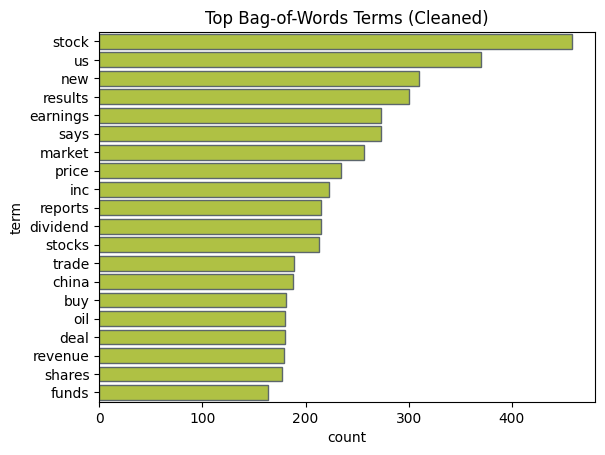

In [23]:
# Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X_train_bow.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color=color_390, edgecolor=color_431)
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

## 7.2. Word2vec - WIP

__`Step 19`__ Apply word2vec to the X_train already preprocessed.

In [24]:
X_train_cleaned_word2vec=preprocess(X_train['text'], word2vec=True)

100%|██████████| 7634/7634 [00:00<00:00, 23980.48it/s]


In [25]:
# Tokenize the tokens column for Word2Vec input
X_train_tokens = [text.split() for text in X_train['tokens']]
X_val_tokens = [text.split() for text in X_val['tokens']]

# model = Word2Vec(
#     sentences=corpus,
#     vector_size=5,    # size of the embedding vectors
#     window=2,         # context window size -  maximum distance between a target word and its context words
#     min_count=1,      # minimum word frequency that a word mus have in the corpus to be included in the modelx
#     sg=1              # 1 for skip-gram; 0 for CBOW (Predict the target word based on its context words.)
# )

# Train Word2Vec model on training data
w2v_model = Word2Vec(sentences=X_train_cleaned_word2vec, vector_size=100, window=5, min_count=1, workers=4, sg=1)

__`Step 20`__ Embeddings for each tweet in the corpus - average of the embeddings of each word in that tweet - suitable for models like KNN and Logistic Regression

In [26]:
def average_embedding(text, model, dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [27]:
# These are embeddings with average (take the average of all the words in the tweet) - suitable for KNN and Logistic Regression
X_train_avgembeddings_from_scratch = np.array([average_embedding(text, w2v_model.wv, dim=dim) for text in X_train_cleaned])
X_val_avgembeddings_from_scratch = np.array([average_embedding(text, w2v_model.wv, dim=dim) for text in X_val_cleaned])

__`Step 21`__ Get the embeddings for each word - do not need to make the average - suitable for RNN and LSTM. These models accepts as inputs vectors of vectors

In [28]:
def corpus2vec(corpus, w2v):
    index_set = set(w2v.index_to_key)  # List of all words/vocabulary in the model
    word_vec = w2v.get_vector           # Creates a short cut that retrieves the embedding method for a given word
    return [
        [word_vec(word) for word in doc.split() if word in index_set]
        for doc in tqdm(corpus)
    ]

In [29]:
# these are embeddings where each word is a vector (not computed the average across words) - suitable for RNN and LSTM
X_train_embeddings_from_scratch = corpus2vec(X_train_cleaned, w2v_model.wv)
X_val_embeddings_from_scratch = corpus2vec(X_val_cleaned, w2v_model.wv)

100%|██████████| 1909/1909 [00:00<00:00, 283441.05it/s]


## 7.3. Word Vectors with Glove (Pretrained Word Vectors)

__`Step 21`__ Download the pretrained word vectors.

In [30]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [31]:
# we will use the one regarding twitter
glove_model_100 = gensim.downloader.load(f'glove-twitter-{dim}')

In [32]:
X_train_avgembeddings_glove = np.array([average_embedding(text, glove_model_100, dim=dim) for text in X_train_cleaned])
X_val_avgembeddings_glove = np.array([average_embedding(text, glove_model_100, dim=dim) for text in X_val_cleaned])

In [33]:
X_train_embeddings_glove = corpus2vec(X_train_cleaned, glove_model_100)
X_val_embeddings_glove = corpus2vec(X_val_cleaned, glove_model_100)

100%|██████████| 1909/1909 [00:00<00:00, 45486.40it/s]


## 7.3. Transformer (Encoder)

In [34]:
MODEL = "assemblyai/distilbert-base-uncased-sst2"
#MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
#MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

In [35]:
model = pipeline("feature-extraction", model=MODEL, tokenizer=MODEL, batch_size=16, truncation=True)

Device set to use cpu


In [36]:
def generate_embeddings(
    texts,
    embeddings_model,
    for_sequence_model=False,
    desc="Generating Embeddings"
):
    """
    Generates either CLS embeddings (1 per text) or full token embeddings (sequence) for each input text.

    Args:
        texts (list of str): List of input texts.
        embeddings_model (callable): Hugging Face pipeline("feature-extraction", ...).
        use_cls (bool): If True, use the CLS token embedding; if False, use mean pooling.
        for_sequence_model (bool): If True, return full token-level embeddings (for RNNs).
        desc (str): tqdm progress bar description.

    Returns:
        If for_sequence_model:
            List[torch.Tensor]: Each tensor is [seq_len, hidden_dim].
        Else:
            torch.Tensor: Tensor of shape [num_texts, hidden_dim].
    """
    processed = []

    for text in tqdm(texts, desc=desc):
        output = embeddings_model(text)  # list[list[list]]
        token_embeddings = output[0]  # get token vectors from the first (and only) item in batch
        token_embeddings = torch.tensor(token_embeddings)  # shape: [seq_len, hidden_dim]

        if for_sequence_model:
            processed.append(token_embeddings)  # shape: [seq_len, hidden_dim]
        else:
            summary_vector = token_embeddings[0]  # [CLS] token embedding
            processed.append(summary_vector)

    if for_sequence_model:
        return processed
    else:
        return torch.stack(processed)  # shape: [num_texts, hidden_dim]


In [37]:
X_train_avgembeddings_transformer=generate_embeddings(X_train_cleaned, model)
X_val_avgembeddings_transformer=generate_embeddings(X_val_cleaned, model)

Generating Embeddings: 100%|██████████| 1909/1909 [01:06<00:00, 28.72it/s]


In [38]:
X_train_embeddings_transformer=generate_embeddings(X_train_cleaned, model, for_sequence_model=True)
X_val_embeddings_transformer=generate_embeddings(X_val_cleaned, model, for_sequence_model=True)

Generating Embeddings: 100%|██████████| 1909/1909 [00:47<00:00, 40.06it/s]


# 8. Classification Models

X_train_avgembeddings_(...) - for KNN and logistic regression models. Each tweet is a vector with the average embeddings of each word
X_train_embeddings_(...) - for RNN and LTSM. Each tweet is a vector of vector. Each word is an embedding, all embaddings have the same size. It is needed padding, done below in the RNN and LSTM section.

## 8.5. Generative AI

In [3]:
with open("..\Azure Open AI Key.txt", "r", encoding="utf-8") as file:
    key = file.read()

# Print or use the variable
key

'4Z9PXYWIJgaPUr9bfzZgHsrjWsQw7TvsKEeHJFaHIqsDRI6NeBOIJQQJ99AJACYeBjFXJ3w3AAABACOGmbpO'

In [5]:
os.environ["AZURE_OPENAI_KEY"] = key
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://novaimsplayground.openai.azure.com/"

In [9]:
llm = AzureChatOpenAI(
                    temperature = 1,
                    model="ChatGPT",
                    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
                    openai_api_type="azure",
                    api_key=os.getenv("AZURE_OPENAI_KEY"),
                    api_version="2024-02-15-preview")

# 9. Evaluation